In [2]:

import torch

def reshape_to_complex(processed_tensor):
    """
    Reshapes a processed tensor from [kx, ky, 2, coil] into a complex tensor of shape [coil, kx, ky].
    
    Args:
        processed_tensor (torch.Tensor): Tensor with shape [kx, ky, 2, coil], where the 2 corresponds to [real, imag].
    
    Returns:
        torch.Tensor: A complex-valued tensor of shape [coil, kx, ky].
    """
    # Permute to bring the coil dimension first: [coil, kx, ky, 2]
    tensor_permuted = processed_tensor.permute(3, 0, 1, 2)
    
    # Convert the last dimension to a complex tensor:
    # The last dimension should have exactly 2 elements, where index 0 is the real part and index 1 is the imaginary part.
    complex_tensor = torch.complex(tensor_permuted[..., 0], tensor_permuted[..., 1])
    
    return complex_tensor



In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def complex_fft2(x):
    """
    x: [B, 2, H, W] => (real, imag) in channels.
    Returns a tensor [B, 2, H, W] with the 2D FFT of x (orthonormal).
    """
    # Separate real and imaginary parts
    real = x[:, 0, :, :]
    imag = x[:, 1, :, :]
    x_complex = torch.complex(real, imag)  # [B, H, W], complex dtype

    # Orthogonal FFT
    X_complex = torch.fft.fft2(x_complex, norm='ortho')

    # Re-split real & imag
    X_real = X_complex.real
    X_imag = X_complex.imag
    return torch.stack([X_real, X_imag], dim=1)  # [B, 2, H, W]

def complex_ifft2(X):
    """
    X: [B, 2, H, W] => (real, imag) in channels.
    Returns a tensor [B, 2, H, W] with the 2D IFFT of X (orthonormal).
    """
    X_real = X[:, 0, :, :]
    X_imag = X[:, 1, :, :]
    X_complex = torch.complex(X_real, X_imag)

    x_complex = torch.fft.ifft2(X_complex, norm='ortho')
    return torch.stack([x_complex.real, x_complex.imag], dim=1)

class DownBlock(nn.Module):
    """
    A typical "down" block in a U-Net:
      - 2x Conv(3x3) + ReLU
      - Then downsample (e.g., MaxPool) unless it's the bottom-most layer
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down


class UpBlock(nn.Module):
    """
    An "up" block in a U-Net:
      - Up-sample (could be ConvTranspose2d or bilinear + Conv)
      - Skip connection from the encoder
      - 2x Conv(3x3) + ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Transpose convolution for upsampling by factor of 2
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # After concatenating skip connection, do standard double-conv
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        # Fix shape mismatch (if skip is bigger)
        diffH = skip.size(2) - x.size(2)
        diffW = skip.size(3) - x.size(3)
        if diffH > 0 or diffW > 0:
            # pad (left, right, top, bottom)
            x = F.pad(x, (0, diffW, 0, diffH), mode='constant', value=0)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    A more traditional U-Net structure.
    For single-coil MRI + complex data, set in_channels=2, out_channels=2.
    For multi-coil, you might want in_channels=2*num_coils, or feed coil maps differently.
    """
    def __init__(self, 
                 in_channels=2, 
                 out_channels=2, 
                 features=[64, 128, 256, 512]):
        super().__init__()
        self.num_downs = len(features)
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        # Construct down blocks
        prev_channels = in_channels
        for f in features:
            self.down_blocks.append(DownBlock(prev_channels, f))
            prev_channels = f

        # Construct up blocks (mirror)
        reversed_feats = list(reversed(features))
        for i in range(len(reversed_feats) - 1):
            self.up_blocks.append(UpBlock(reversed_feats[i], reversed_feats[i+1]))

        # Final 1x1 conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, t=None, cond=None):
        """
        If cond is not None, we can concatenate it with x or inject in some other manner.
        For example, if cond has shape [B, cond_channels, H, W], do x=cat([x,cond], dim=1).
        """
        if cond is not None:
            x = torch.cat([x, cond], dim=1)

        # Encoder pathway
        skip_connections = []
        out = x
        for down in self.down_blocks:
            skip, out = down(out)
            skip_connections.append(skip)

        # The bottom of the U is skip_connections[-1] (no more pooling there).
        # But we can rename out to reflect that it is the bottom-most activation
        bottom = skip_connections[-1]

        # Decoder pathway
        # We'll pop from skip_connections from the end
        skip_connections = skip_connections[:-1]  # remove the bottom-most
        up_out = bottom
        for i, up in enumerate(self.up_blocks):
            skip_i = skip_connections[-(i+1)]  # take last skip first
            up_out = up(up_out, skip_i)

        # Final projection
        return self.final_conv(up_out)
        
class DDIM(nn.Module):
    def __init__(
        self,
        unet,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        schedule="linear",
        device='cpu'
    ):
        super(DDIM, self).__init__()
        self.unet = unet.to(device)
        self.timesteps = timesteps
        self.device = device

        # Create betas (noise schedule)
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        elif schedule == "cosine":
            self.betas = self._cosine_beta_schedule(timesteps).to(device)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")

        # Alphas and related quantities
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]]
        )
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def _cosine_beta_schedule(self, timesteps, warmup_frac=0.02):
        warmup_steps = int(timesteps * warmup_frac)
        steps = torch.arange(timesteps + 1, dtype=torch.float64, device=self.device)
        s = 0.008
        alphas_cumprod_full = torch.cos(((steps / timesteps) + s) / (1 + s) * (torch.pi / 2))**2
        alphas_cumprod_full = alphas_cumprod_full / alphas_cumprod_full[0]
        if warmup_steps > 0:
            alpha_end_warmup = alphas_cumprod_full[warmup_steps]
            warmup_range = torch.linspace(1.0, alpha_end_warmup, warmup_steps + 1, device=self.device)
            alphas_cumprod_full[: warmup_steps + 1] = warmup_range
        betas = 1 - (alphas_cumprod_full[1:] / alphas_cumprod_full[:-1])
        return betas.float()

    def forward_diffusion(self, x_start, t):
        """
        Diffuse x_start to x_t by adding noise.
        x_start: [B, 2, H, W], real & imag
        t: [B], time steps
        """
        noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x_t = sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
        return x_t, noise

    def forward(self, x, t, cond=None):
        """
        Training pass. The U-Net predicts noise given x_t at time t (plus optional cond).
        """
        return self.unet(x, t, cond=cond)

    ### --- Improved K-space Data Consistency --- ###
    def enforce_data_consistency(self, x_pred, x_measured_k, mask):
        """
        Enforce that the predicted image has the same k-space values
        where data is known (mask=1). Single-coil example.

        Args:
          x_pred: [B, 2, H, W] image domain (real, imag)
          x_measured_k: [B, 2, H, W] measured k-space data (real, imag)
          mask: [B, 1, H, W] or [B, 2, H, W] where 1 indicates known k-space entries
                (if shape is [B,1,H,W], we’ll broadcast to match [B,2,H,W])

        Returns:
          new_x_pred: the updated image after substituting known k-space lines.
        """
        # 1) Transform predicted image to frequency domain
        X_pred_k = complex_fft2(x_pred)  # [B, 2, H, W]

        # 2) Merge with measured data in the known region
        #    Expand mask to 2 channels if necessary
        if mask.shape[1] == 1:
            mask = mask.repeat(1, 2, 1, 1)  # now [B,2,H,W]

        X_updated = X_pred_k * (1 - mask) + x_measured_k * mask

        # 3) Go back to image domain
        x_updated = complex_ifft2(X_updated)
        return x_updated

    def reverse_diffusion(self, x_t, t, x_measured_k=None, mask=None, eta=0):
        """
        Single step of reverse diffusion. Optionally enforce data consistency in k-space.

        x_t: [B, 2, H, W], the noisy image at time t.
        x_measured_k: [B, 2, H, W], the measured k-space data (optional).
        mask: [B, 2, H, W] or [B, 1, H, W], indicates known k-space lines (1=> known).
        eta: noise level for DDIM sampling.
        """
        cond = None
        if (x_measured_k is not None) and (mask is not None):
            # In advanced usage, you might feed the measured data or mask as additional channels
            # to the U-Net. For now, we just do a direct call:
            cond = None  # or torch.cat([some_image, mask], dim=1)

        # 1) Predict noise using the U-Net
        pred_noise = self.unet(x_t, t, cond=cond)

        alpha = self.alphas[t][:, None, None, None]
        alpha_cumprod = self.alphas_cumprod[t][:, None, None, None]
        alpha_cumprod_prev = self.alphas_cumprod_prev[t][:, None, None, None]

        # 2) Estimate x_0 from x_t
        pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod) * pred_noise) / torch.sqrt(alpha_cumprod)
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # 3) Compute the mean for x_{t-1}
        pred_mean = torch.sqrt(alpha_cumprod_prev) * pred_x0 + \
                    torch.sqrt(1 - alpha_cumprod_prev) * pred_noise

        # 4) Add optional stochasticity
        if eta > 0:
            noise = torch.randn_like(x_t)
            sigma = eta * torch.sqrt(self.posterior_variance[t])[:, None, None, None]
            pred_mean = pred_mean + sigma * noise

        # 5) Data consistency in k-space (if we have measured data)
        if (x_measured_k is not None) and (mask is not None):
            pred_mean = self.enforce_data_consistency(
                x_pred=pred_mean, 
                x_measured_k=x_measured_k, 
                mask=mask
            )

        return pred_mean

    def sample(self, shape, x_measured_k=None, mask=None, eta=0):
        """
        Generate samples using reverse diffusion, enforcing k-space consistency if x_measured_k, mask are provided.

        shape: (batch_size, 2, H, W) for single-coil real+imag
        x_measured_k: [B, 2, H, W]
        mask: [B, 1, H, W] or [B, 2, H, W], same spatial size, 1 => known data
        eta: additional noise factor for DDIM

        Returns final x_0 in image domain.
        """
        x_t = torch.randn(shape, device=self.device)
        for timestep in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), timestep, device=self.device, dtype=torch.long)
            x_t = self.reverse_diffusion(
                x_t, t_tensor, x_measured_k=x_measured_k, mask=mask, eta=eta
            )
        return x_t

In [3]:

processed_data = torch.load("mri-2/fs_0020_3T_slice0_phase13.pt") 
complex_data = reshape_to_complex(processed_data)
print("Complex data shape:", complex_data.shape)  # Expected shape: [coil, kx, ky]


Complex data shape: torch.Size([34, 384, 144])


Original sample shape: torch.Size([384, 144, 2, 38])
After permute: torch.Size([2, 38, 384, 144])
After flattening channels: torch.Size([76, 384, 144])
k-space output shape: torch.Size([1, 76, 384, 144])


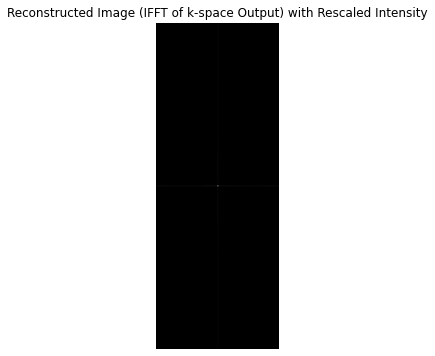

In [38]:
import torch
import torch.fft
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Hyperparameters and device setup
global_max_channels = 76        
timesteps = 1000
schedule = "cosine"
beta_start = 1e-4
beta_end = 0.02
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assume UNet and DDIM classes have been defined/imported appropriately.
# Instantiate the model with the same configuration as during training.
unet = UNet(
    in_channels=global_max_channels,    # should match the global_max_channels used in training
    out_channels=global_max_channels,
    features=[64, 128, 256],
)
ddim = DDIM(
    unet=unet,
    timesteps=timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    schedule=schedule,
    device=device
)

# Load the saved state dictionary
state_dict = torch.load("models/new_2_model.pt", map_location=device)
ddim.load_state_dict(state_dict)
ddim.to(device)
ddim.eval()

# --- Load a sample input ---
# shape [kx, ky, 2, coil]
sample = torch.load("mri-2/fs_0020_3T_slice0_phase19.pt", map_location=device)
print("Original sample shape:", sample.shape)  # e.g. [kx, ky, 2, coil]

# Permute from [kx, ky, 2, coil] to [2, coil, kx, ky]
sample = sample.permute(2, 3, 0, 1)
print("After permute:", sample.shape)  # Expected: [2, coil, kx, ky]

# Flatten the first two dimensions to get [C, kx, ky] with C = 2*coil.
sample = sample.reshape(-1, sample.shape[-2], sample.shape[-1])
print("After flattening channels:", sample.shape)  # e.g. [68, kx, ky]

# Pad (or crop) the channel dimension to match global_max_channels.
if sample.shape[0] < global_max_channels:
    pad_channels = global_max_channels - sample.shape[0]
    sample = F.pad(sample, (0, 0, 0, 0, 0, pad_channels))
    print("After padding, sample shape:", sample.shape)
elif sample.shape[0] > global_max_channels:
    sample = sample[:global_max_channels, :, :]
    print("After cropping, sample shape:", sample.shape)

# Add a batch dimension: now [1, C, H, W]
sample = sample.unsqueeze(0).to(device)

# --- Run the model ---
with torch.no_grad():
    t = torch.randint(0, timesteps, (sample.size(0),), device=device).long()
    kspace_output = ddim(sample, t=t, cond=None)
    # kspace_output should have shape [B, global_max_channels, H, W]
print("k-space output shape:", kspace_output.shape)

# --- Convert k-space output to image domain ---
B, C, H, W = kspace_output.shape
if C % 2 != 0:
    raise ValueError("Expected an even number of channels (coil*2).")
num_coils = C // 2

# Reshape to separate coil and complex dimensions: [B, num_coils, 2, H, W]
kspace_reshaped = kspace_output.view(B, num_coils, 2, H, W)
# Convert to a complex tensor: first channel is real, second is imaginary.
kspace_complex = torch.complex(kspace_reshaped[:, :, 0, :, :],
                                kspace_reshaped[:, :, 1, :, :])
# kspace_complex now has shape: [B, num_coils, H, W]

# Optionally apply ifftshift to center k-space
if True:
    kspace_complex = torch.fft.ifftshift(kspace_complex, dim=(-2, -1))

# Perform a 2D inverse FFT (with orthogonal normalization)
image_coils = torch.fft.ifft2(kspace_complex, norm='ortho')

# Optionally apply fftshift to recenter the image
if True:
    image_coils = torch.fft.fftshift(image_coils, dim=(-2, -1))

# Compute the magnitude for each coil image
coil_magnitudes = torch.abs(image_coils)

# Combine coil images using the Sum-Of-Squares (SOS) method: result [B, H, W]
reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))

# --- Rescale intensity via min–max normalization ---
img_min = reconstructed_image.min()
img_max = reconstructed_image.max()
reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)

# For visualization, take the first image in the batch
img_to_show = reconstructed_image[0].cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(img_to_show, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output) with Rescaled Intensity")
plt.axis("off")
plt.show()


In [17]:
import torch
import torch.fft
import torch.nn.functional as F
import matplotlib.pyplot as plt

def pad_coils_to_expected(tensor, expected_coils):
    """
    Pads (or crops) a tensor of shape [coil, 2, H, W] along the coil dimension
    so that its number of coils becomes expected_coils.
    """
    current_coils = tensor.shape[0]
    if current_coils < expected_coils:
        pad_coils = expected_coils - current_coils
        # Pad on the coil dimension (dimension 0)
        tensor = F.pad(tensor, (0, 0, 0, 0, 0, pad_coils))
    elif current_coils > expected_coils:
        tensor = tensor[:expected_coils, :, :, :]
    return tensor

def reconstruct_image(pt_file, global_max_channels, do_shift=True):
    """
    Reconstructs an image from k-space data stored in a .pt file.
    The k-space data is assumed to have shape [kx, ky, 2, coil],
    where 2 corresponds to [real, imag] and 'coil' is the number of coils.

    The function:
      1. Loads the k-space data.
      2. Permutes the data from [kx, ky, 2, coil] to [coil, 2, kx, ky].
      3. Pads (or crops) the coil dimension so that the number of coils equals expected_coils,
         where expected_coils = global_max_channels // 2.
      4. Converts the two channels into a complex tensor.
      5. Optionally applies ifftshift to center k-space.
      6. Performs a 2D inverse FFT to get image domain data.
      7. Optionally applies fftshift to recenter the image.
      8. Computes the magnitude image for each coil.
      9. Combines coils using the Sum-Of-Squares (SOS) method.
      10. Scales the intensity via min–max normalization and displays the result.

    Args:
        pt_file (str): Path to the .pt file (expected shape: [kx, ky, 2, coil]).
        global_max_channels (int): Target flattened channel count (must be even; i.e. global_max_channels = expected_coils * 2).
        do_shift (bool): If True, applies ifftshift before IFFT and fftshift after.
    """
    # Load the k-space sample (expected shape: [kx, ky, 2, coil])
    sample = torch.load(pt_file)
    print(f"Loaded sample shape: {sample.shape}")  # e.g., [kx, ky, 2, coil]

    # Permute to bring the coil and complex dimensions to the front: [coil, 2, kx, ky]
    sample = sample.permute(3, 2, 0, 1)
    print(f"After permute: {sample.shape}")

    # Determine expected number of coils
    if global_max_channels % 2 != 0:
        raise ValueError("global_max_channels must be even (global_max_channels = num_coils * 2).")
    expected_coils = global_max_channels // 2

    # Pad (or crop) the coil dimension to match expected_coils.
    sample = pad_coils_to_expected(sample, expected_coils)
    print(f"After padding/cropping coils: {sample.shape}")  # Should be [expected_coils, 2, kx, ky]

    # Convert to a complex tensor: combine the two channels (0: real, 1: imag)
    kspace_complex = torch.complex(sample[:, 0, :, :], sample[:, 1, :, :])
    print(f"Complex k-space shape: {kspace_complex.shape}")  # [expected_coils, kx, ky]

    # Optionally apply ifftshift to center k-space (if data is not centered)
    if do_shift:
        kspace_complex = torch.fft.ifftshift(kspace_complex, dim=(-2, -1))

    # Perform a 2D inverse FFT to get image domain data (using orthonormal normalization)
    image_coils = torch.fft.ifft2(kspace_complex, norm='ortho')

    # Optionally, apply fftshift to recenter the image domain data
    if do_shift:
        image_coils = torch.fft.fftshift(image_coils, dim=(-2, -1))

    # Compute the magnitude image for each coil
    coil_magnitudes = torch.abs(image_coils)

    # Combine coils using the Sum-Of-Squares (SOS) method (resulting shape: [kx, ky])
    sos = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=0))

    # Rescale intensity via min–max normalization
    sos_min = sos.min()
    sos_max = sos.max()
    sos_scaled = (sos - sos_min) / (sos_max - sos_min + 1e-8)

    # Display the reconstructed image
    plt.figure(figsize=(6, 6))
    plt.imshow(sos_scaled.cpu().numpy(), cmap='gray')
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()


Loaded sample shape: torch.Size([384, 144, 2, 38])
After permute: torch.Size([38, 2, 384, 144])
After padding/cropping coils: torch.Size([38, 2, 384, 144])
Complex k-space shape: torch.Size([38, 384, 144])


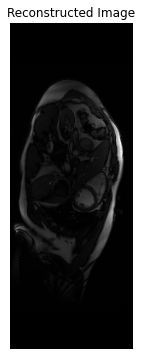

In [37]:
pt_file = "mri-2/fs_0020_3T_slice0_phase19.pt"
global_max_channels = 76
reconstruct_image(pt_file, global_max_channels,do_shift=True)

In [28]:
def show_kspace(pt_file, global_max_channels, do_shift=True):
    """
    Loads k-space data from a .pt file and displays its magnitude instead of reconstructing
    the image domain. The k-space data is assumed to have shape [kx, ky, 2, coil],
    where 2 corresponds to [real, imag] and 'coil' is the number of coils.

    The function:
      1. Loads the k-space data.
      2. Permutes the data from [kx, ky, 2, coil] to [coil, 2, kx, ky].
      3. Pads (or crops) the coil dimension so that the number of coils equals expected_coils,
         where expected_coils = global_max_channels // 2.
      4. Converts the two channels into a complex tensor.
      5. Optionally applies fftshift to center k-space for visualization.
      6. Computes the magnitude for each coil.
      7. Combines coils using the Sum-Of-Squares (SOS) method.
      8. Scales the intensity via min–max normalization and displays the result.

    Args:
        pt_file (str): Path to the .pt file (expected shape: [kx, ky, 2, coil]).
        global_max_channels (int): Target flattened channel count (must be even; i.e. global_max_channels = expected_coils * 2).
        do_shift (bool): If True, applies fftshift to center k-space before display.
    """
    import torch
    import matplotlib.pyplot as plt

    # Load the k-space sample (expected shape: [kx, ky, 2, coil])
    sample = torch.load(pt_file)
    print(f"Loaded sample shape: {sample.shape}")  # e.g., [kx, ky, 2, coil]

    # Permute to bring the coil and complex dimensions to the front: [coil, 2, kx, ky]
    sample = sample.permute(3, 2, 0, 1)
    print(f"After permute: {sample.shape}")

    # Determine expected number of coils
    if global_max_channels % 2 != 0:
        raise ValueError("global_max_channels must be even (global_max_channels = num_coils * 2).")
    expected_coils = global_max_channels // 2

    # Pad (or crop) the coil dimension to match expected_coils.
    sample = pad_coils_to_expected(sample, expected_coils)
    print(f"After padding/cropping coils: {sample.shape}")  # Should be [expected_coils, 2, kx, ky]

    # Convert to a complex tensor: combine the two channels (0: real, 1: imag)
    kspace_complex = torch.complex(sample[:, 0, :, :], sample[:, 1, :, :])
    print(f"Complex k-space shape: {kspace_complex.shape}")  # [expected_coils, kx, ky]

    # Optionally apply fftshift to center k-space for display (so that low frequencies appear in the center)
    if do_shift:
        kspace_complex = torch.fft.fftshift(kspace_complex, dim=(-2, -1))

    # Compute the magnitude for each coil
    coil_magnitudes = torch.abs(kspace_complex)

    # Combine coils using the Sum-Of-Squares (SOS) method (resulting shape: [kx, ky])
    sos = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=0))

    # Rescale intensity via min–max normalization
    sos_min = sos.min()
    sos_max = sos.max()
    sos_scaled = (sos - sos_min) / (sos_max - sos_min + 1e-8)

    # Display the k-space magnitude
    plt.figure(figsize=(6, 6))
    plt.imshow(sos_scaled.cpu().numpy(), cmap='gray')
    plt.title("K-Space Magnitude")
    plt.axis("off")
    plt.show()



Loaded sample shape: torch.Size([448, 176, 2, 34])
After permute: torch.Size([34, 2, 448, 176])
After padding/cropping coils: torch.Size([34, 6, 448, 176])
Complex k-space shape: torch.Size([34, 448, 176])


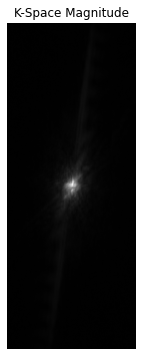

In [30]:
pt_file = "mri-2/fs_0020_3T_slice0_phase19.pt"
global_max_channels = 76
show_kspace(pt_file, global_max_channels,do_shift=False)